In [1]:
from tensorflow import keras
from PIL import Image
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import torch
import random
from torchvision import models, transforms
from scipy.spatial import distance_matrix
import numpy as np
import copy

In [2]:
sample_size = 20
batchSize = 20
MARGIN = 3

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [4]:
toTensor = transforms.ToTensor()


xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

In [5]:
negative_i_dict = {}

for label in set(ySub):
    negative_i_dict[label] = [i for i in range(len(ySub)) if ySub[i] != label ]

negative_i_dict

{0: [0, 1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 19],
 1: [0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19],
 2: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19],
 4: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 5: [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19],
 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
 7: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19],
 9: [0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 13, 14, 15, 17, 18, 19]}

In [6]:


model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

optimizer = optim.SGD( model.parameters() )
criterion = nn.TripletMarginLoss(p=1, # Manhatten Distance
                                 margin=MARGIN
                                 )

In [7]:


def get_n_index(a_index, label, labels, ap_dist, dMatrix):
    row = copy.deepcopy( dMatrix[a_index] )

    for i in range(sample_size):
        if ap_dist + MARGIN < row[i]: row[i] = 0   # Only look at cases where negative is closer than postive (plus Margin)
        if labels[i] == label: row[i] = 0           # Only look at Negative Cases
        if not (ap_dist < row[i]): row[i] = 0       # Only looking at semi-Hard Negatives


    max_dist = max(row)
    if max_dist == 0: return []
    
    n_index = list(row).index( max_dist )
    return [n_index] # Local index of the longest distance

In [8]:
def get_apnForRow( label , labels , a_index , dMatrix ):
    apn_list = []

    row = copy.deepcopy( dMatrix[a_index] )
    for i in range(sample_size):
        if (labels[i] == label) and (i != a_index):
            p_index = i
            ap_dist = row[p_index]
            
            apn_list += [(a_index, p_index, n_index) for n_index in get_n_index( a_index, label, labels, ap_dist, dMatrix)]

    return apn_list


In [9]:
def get_apn_list(labels , dMatrix):
    apn_list = []

    for i in range(sample_size):
        label = labels[i]
        a_index = i

        apn_list += get_apnForRow( label , labels , a_index, dMatrix )

    return apn_list

# get_apn_list(ySub , dMatrix)

In [10]:
import random


for i in range(1000):
    
    batch_i = random.sample(range(sample_size), batchSize)

    xBatch = torch.stack( [xTensor[j] for j in batch_i] )
    yBatch = [ySub[j] for j in batch_i]

    results = model(xBatch)
    results_np = results.detach().numpy()

    dMatrix = distance_matrix(results_np, results_np, p=1)

    local_APN_list = get_apn_list(ySub , dMatrix)

    a_list = []
    p_list = []
    n_list = []

    for apn in local_APN_list:
        a_list.append(results[ batch_i[apn[0]] ])
        p_list.append(results[ batch_i[apn[1]] ])
        n_list.append(results[ batch_i[apn[2]] ])
    
    # === Improve Model ===
    optimizer.zero_grad()

    loss = criterion(torch.stack(a_list),
                    torch.stack(p_list),
                    torch.stack(n_list) )
    
    loss.backward()
    optimizer.step()

    print(i, loss)

0 tensor(2.9719, grad_fn=<MeanBackward0>)
1 tensor(2.9796, grad_fn=<MeanBackward0>)
2 tensor(2.9834, grad_fn=<MeanBackward0>)
3 tensor(2.9953, grad_fn=<MeanBackward0>)
4 tensor(3.0067, grad_fn=<MeanBackward0>)
5 tensor(3.0105, grad_fn=<MeanBackward0>)
6 tensor(3.0031, grad_fn=<MeanBackward0>)
7 tensor(2.9939, grad_fn=<MeanBackward0>)
8 tensor(2.9969, grad_fn=<MeanBackward0>)
9 tensor(2.9857, grad_fn=<MeanBackward0>)
10 tensor(3.0097, grad_fn=<MeanBackward0>)
11 tensor(2.9983, grad_fn=<MeanBackward0>)
12 tensor(2.9965, grad_fn=<MeanBackward0>)
13 tensor(2.9964, grad_fn=<MeanBackward0>)
14 tensor(2.9856, grad_fn=<MeanBackward0>)
15 tensor(3.0050, grad_fn=<MeanBackward0>)
16 tensor(2.9787, grad_fn=<MeanBackward0>)
17 tensor(3.0069, grad_fn=<MeanBackward0>)
18 tensor(2.9900, grad_fn=<MeanBackward0>)
19 tensor(2.9682, grad_fn=<MeanBackward0>)
20 tensor(2.9811, grad_fn=<MeanBackward0>)
21 tensor(2.9999, grad_fn=<MeanBackward0>)
22 tensor(2.9913, grad_fn=<MeanBackward0>)
23 tensor(3.0087, gra

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Step 1: Perform K-Means Clustering
def kmeans_clustering(hash_codes, n_clusters=10, n_init=10, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)
    clusters = kmeans.fit_predict(hash_codes)
    return clusters

# Step 2: Build the label-cluster matrix
def build_label_cluster_matrix(clusters, true_labels, n_clusters=10):
    # Initialize a matrix to count label-cluster relationships  
    label_cluster_matrix = np.zeros((10, n_clusters), dtype=int)
    
    for label, cluster in zip(true_labels, clusters):
        label_cluster_matrix[label][cluster] += 1
    
    return label_cluster_matrix

# Step 3: Visualize the result as a heatmap
def plot_heatmap(label_cluster_matrix):
    plt.figure(figsize=(10, 6))
    sns.heatmap(label_cluster_matrix, annot=True, fmt="d", cmap="Blues", cbar=True)
    plt.title("Label Distribution Across Clusters")
    plt.xlabel("Clusters")
    plt.ylabel("True Labels")
    plt.show()


def easyHeatmap(hashCodes, labels):
    raw_clusters = kmeans_clustering(hashCodes, n_clusters=10)

    raw_label_cluster_matrix = build_label_cluster_matrix(raw_clusters, labels)

    plot_heatmap(raw_label_cluster_matrix)

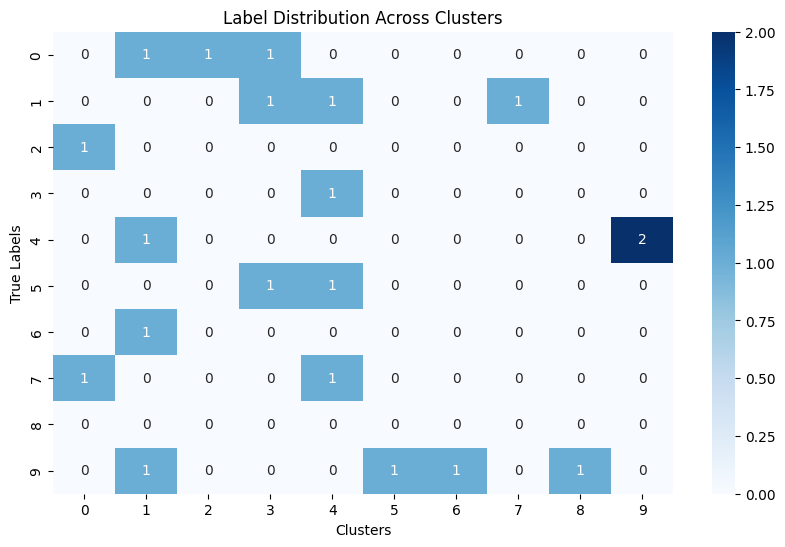

In [12]:
easyHeatmap(model(xTensor).detach().numpy(), ySub)

In [13]:
toTensor = transforms.ToTensor()

sample_size = 5000
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xBatch = xTensor

results = model(xBatch)
results_np = results.detach().numpy()

dMatrix = distance_matrix(results_np, results_np, p=1)


In [14]:
model = nn.Sequential(  nn.Flatten(),
                        nn.Linear(28*28,512),
                        nn.ReLU(),
                        nn.Linear(512,256),
                        nn.ReLU(),
                        nn.Linear(256,32),
                        nn.Sigmoid()
                        )

In [15]:
toTensor = transforms.ToTensor()

sample_size = 20
xSub = x_train[:sample_size]
ySub = y_test[:sample_size]

xTensor = toTensor(xSub)
xTensor = xTensor.permute(1, 0, 2).reshape(len(xSub), 1, 28, 28) # shape: (28, sample_size, 28) -->  shape: (sample_size, 1, 28, 28)

xBatch = xTensor

results = model(xBatch)
results_np = results.detach().numpy()

dMatrix = distance_matrix(results_np, results_np, p=1)
dMatrix.shape

(20, 20)